In [975]:
!pip install pivottablejs

In [827]:
!pip install Xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 162.5 kB/s eta 0:12:49
   ---------------------------------------- 0.0/124.9 MB 186.2 kB/s eta 0:11:11
   ---------------------------------------- 0.0/124.9 MB 217.9 kB/s eta 0:09:34
   ---------------------------------------- 0.1/124.9 MB 280.5 kB/s eta 0:07:25
   ---------------------------------------- 0.1/124.9 MB 346.5 kB/s eta 0:06:01
   ---------------------------------------- 0.1/124.9 MB 400.9 kB/s eta 0:05:12
   ---------------------------------------- 0.2/124.9 MB 437.1 kB/s eta 0:04:46
   ---------------------------------------- 0.2/124.9 MB 504.4 kB/s eta 0:04:08
   ---------------------------------------- 0.3/124.9 MB 632.9 kB/s eta 0:03:17
   ---------------------------------------- 0.4/124.9 MB 739.0 kB/s eta 0:02:49
   ---------------------------------------- 0.4/124.9 MB 7

In [977]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pivottablejs import pivot_ui
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [226]:
# filter warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [67]:
# set to display any number of columns or rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max.rows', None)

In [888]:
df_explore = pd.read_csv('diabetes.csv')

In [894]:
df_explore.duplicated().any()

False

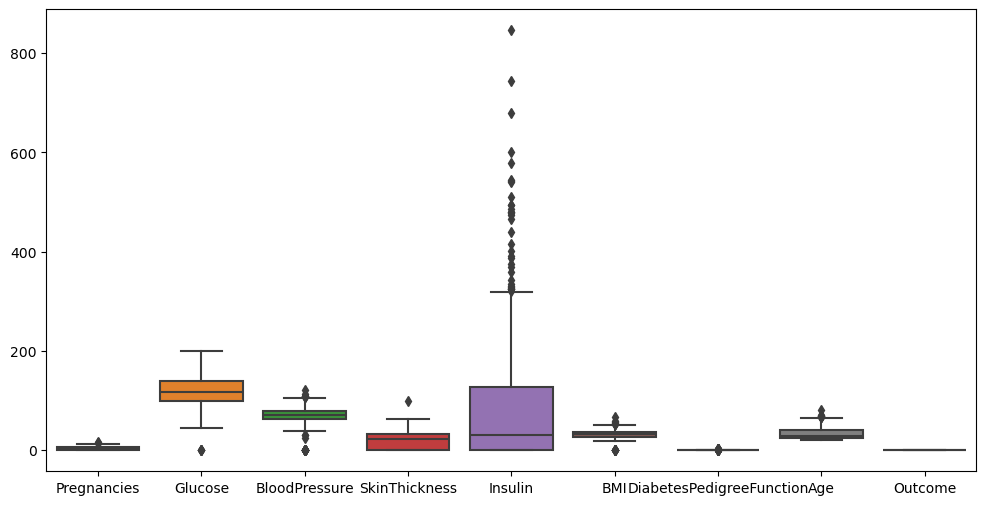

In [896]:
# to iplt.figure(figsize=(12,6))
sns.boxplot(data=df_explore);

In [890]:
# checked for zero values 
zero_values = (df_explore.drop(columns=['Outcome','Pregnancies'])==0)
zero_values.sum()

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

DATA EXPLORATION AND CLEANING PROCESS
---
The data on exploration reveals a lot of zero figures and no duplicate data. Excluding the pregnancy and outcome columns, no other column should in real sense have a zero value, this is an indication of missing data. This is considered (medical study) a 'missing at random' case.        
   
To impute the missing data, I will be taking advantage of the relationships between the feature and the correlation with RandomForest using IterativeImputer. 

Presence of outliers: The outliers were identified and handled using the boxplot and IQR method respectively, however, the model performed better with the outliers, 
so the outliers were recalled. Since I will be working on classification model which is not sensitive to outliers. 



In [724]:
def wrangle(file):
    """
    Load, clean, and preprocess the diabetes dataset.
    
    Args:
        file (str): Path to the CSV file containing the diabetes dataset.
        
    Returns:
        pd.DataFrame: Cleaned and preprocessed dataframe with missing values imputed
                      and outliers removed.
    """

    
    # Load the dataset from a CSV file
    df = pd.read_csv(file)

     # Drop the 'Outcome' and 'Pregnancies' columns for imputation
    zero_df = df.drop(columns=['Outcome','Pregnancies'])

    # Replace zero values with NaN to signify missing data
    zero_df.replace(0,np.nan, inplace=True)

    #Initialize RandomForesrRegressor with parameters
    rf_regressor = RandomForestRegressor(
    n_estimators=100,  # Ensure a sufficient number of trees
    random_state=42,   # Control randomness for reproducibility
    bootstrap=False,   # Control internal randomness
    max_features='sqrt'  # Control feature selection randomness
    )
    # Initialize the IterativeImputer with RandomForestRegressor
    imputer = IterativeImputer(estimator=rf_regressor, random_state=42, max_iter=10)
    
    # Impute missing values
    df_imputed = imputer.fit_transform(zero_df)
    
    # Convert the imputed array back to a DataFrame
    df_imputed = pd.DataFrame(df_imputed, columns=zero_df.columns)

    #concatenate the imputed data with the dropped columns
    df_final = pd.concat([df_imputed,df[['Pregnancies','Outcome']]], axis=1)
    
        
    return df_final

In [726]:
df = wrangle('diabetes.csv')

In [738]:
df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies,Outcome
0,148.0,72.0,35.00,166.81,33.6,0.627,50.0,6,1
1,85.0,66.0,29.00,52.20,26.6,0.351,31.0,1,0
2,183.0,64.0,19.12,226.61,23.3,0.672,32.0,8,1
3,89.0,66.0,23.00,94.00,28.1,0.167,21.0,1,0
4,137.0,40.0,35.00,168.00,43.1,2.288,33.0,0,1


In [730]:
df.isnull().any()

Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Pregnancies                 False
Outcome                     False
dtype: bool

In [732]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   768 non-null    float64
 1   BloodPressure             768 non-null    float64
 2   SkinThickness             768 non-null    float64
 3   Insulin                   768 non-null    float64
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    float64
 7   Pregnancies               768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


### EDA TO FIND PATTERNS _ RISK ANALYSIS

In [734]:
# calculating the correlation matrix to understand the correlation between variables and estimate predictive power. 
corr_matrix = df.corr()
corr_matrix

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies,Outcome
Glucose,1.000000,0.231101,0.236191,0.634887,0.239592,0.138364,0.268190,0.129719,0.496430
BloodPressure,0.231101,1.000000,0.240160,0.152685,0.299079,0.002001,0.331267,0.212935,0.177758
SkinThickness,0.236191,0.240160,1.000000,0.249418,0.690089,0.134565,0.136509,0.090407,0.265219
Insulin,0.634887,0.152685,0.249418,1.000000,0.280211,0.135855,0.294382,0.067615,0.331876
BMI,0.239592,0.299079,0.690089,0.280211,1.000000,0.156164,0.030305,0.021858,0.315196
DiabetesPedigreeFunction,0.138364,0.002001,0.134565,0.135855,0.156164,1.000000,0.033561,-0.033523,0.173844
Age,0.268190,0.331267,0.136509,0.294382,0.030305,0.033561,1.000000,0.544341,0.238356
Pregnancies,0.129719,0.212935,0.090407,0.067615,0.021858,-0.033523,0.544341,1.000000,0.221898
Outcome,0.496430,0.177758,0.265219,0.331876,0.315196,0.173844,0.238356,0.221898,1.000000


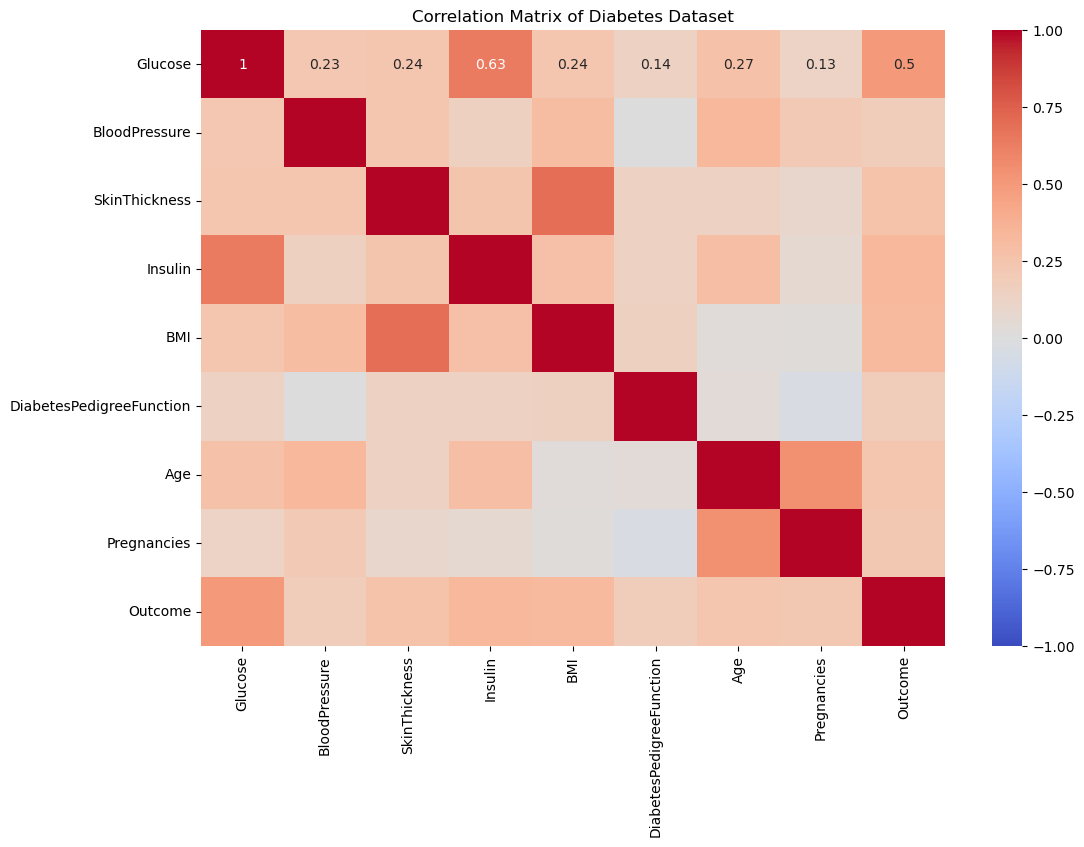

In [736]:
# plotting the correlation matrix to understand the level of correlation and identify multicollinearity
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Diabetes Dataset')
plt.show()

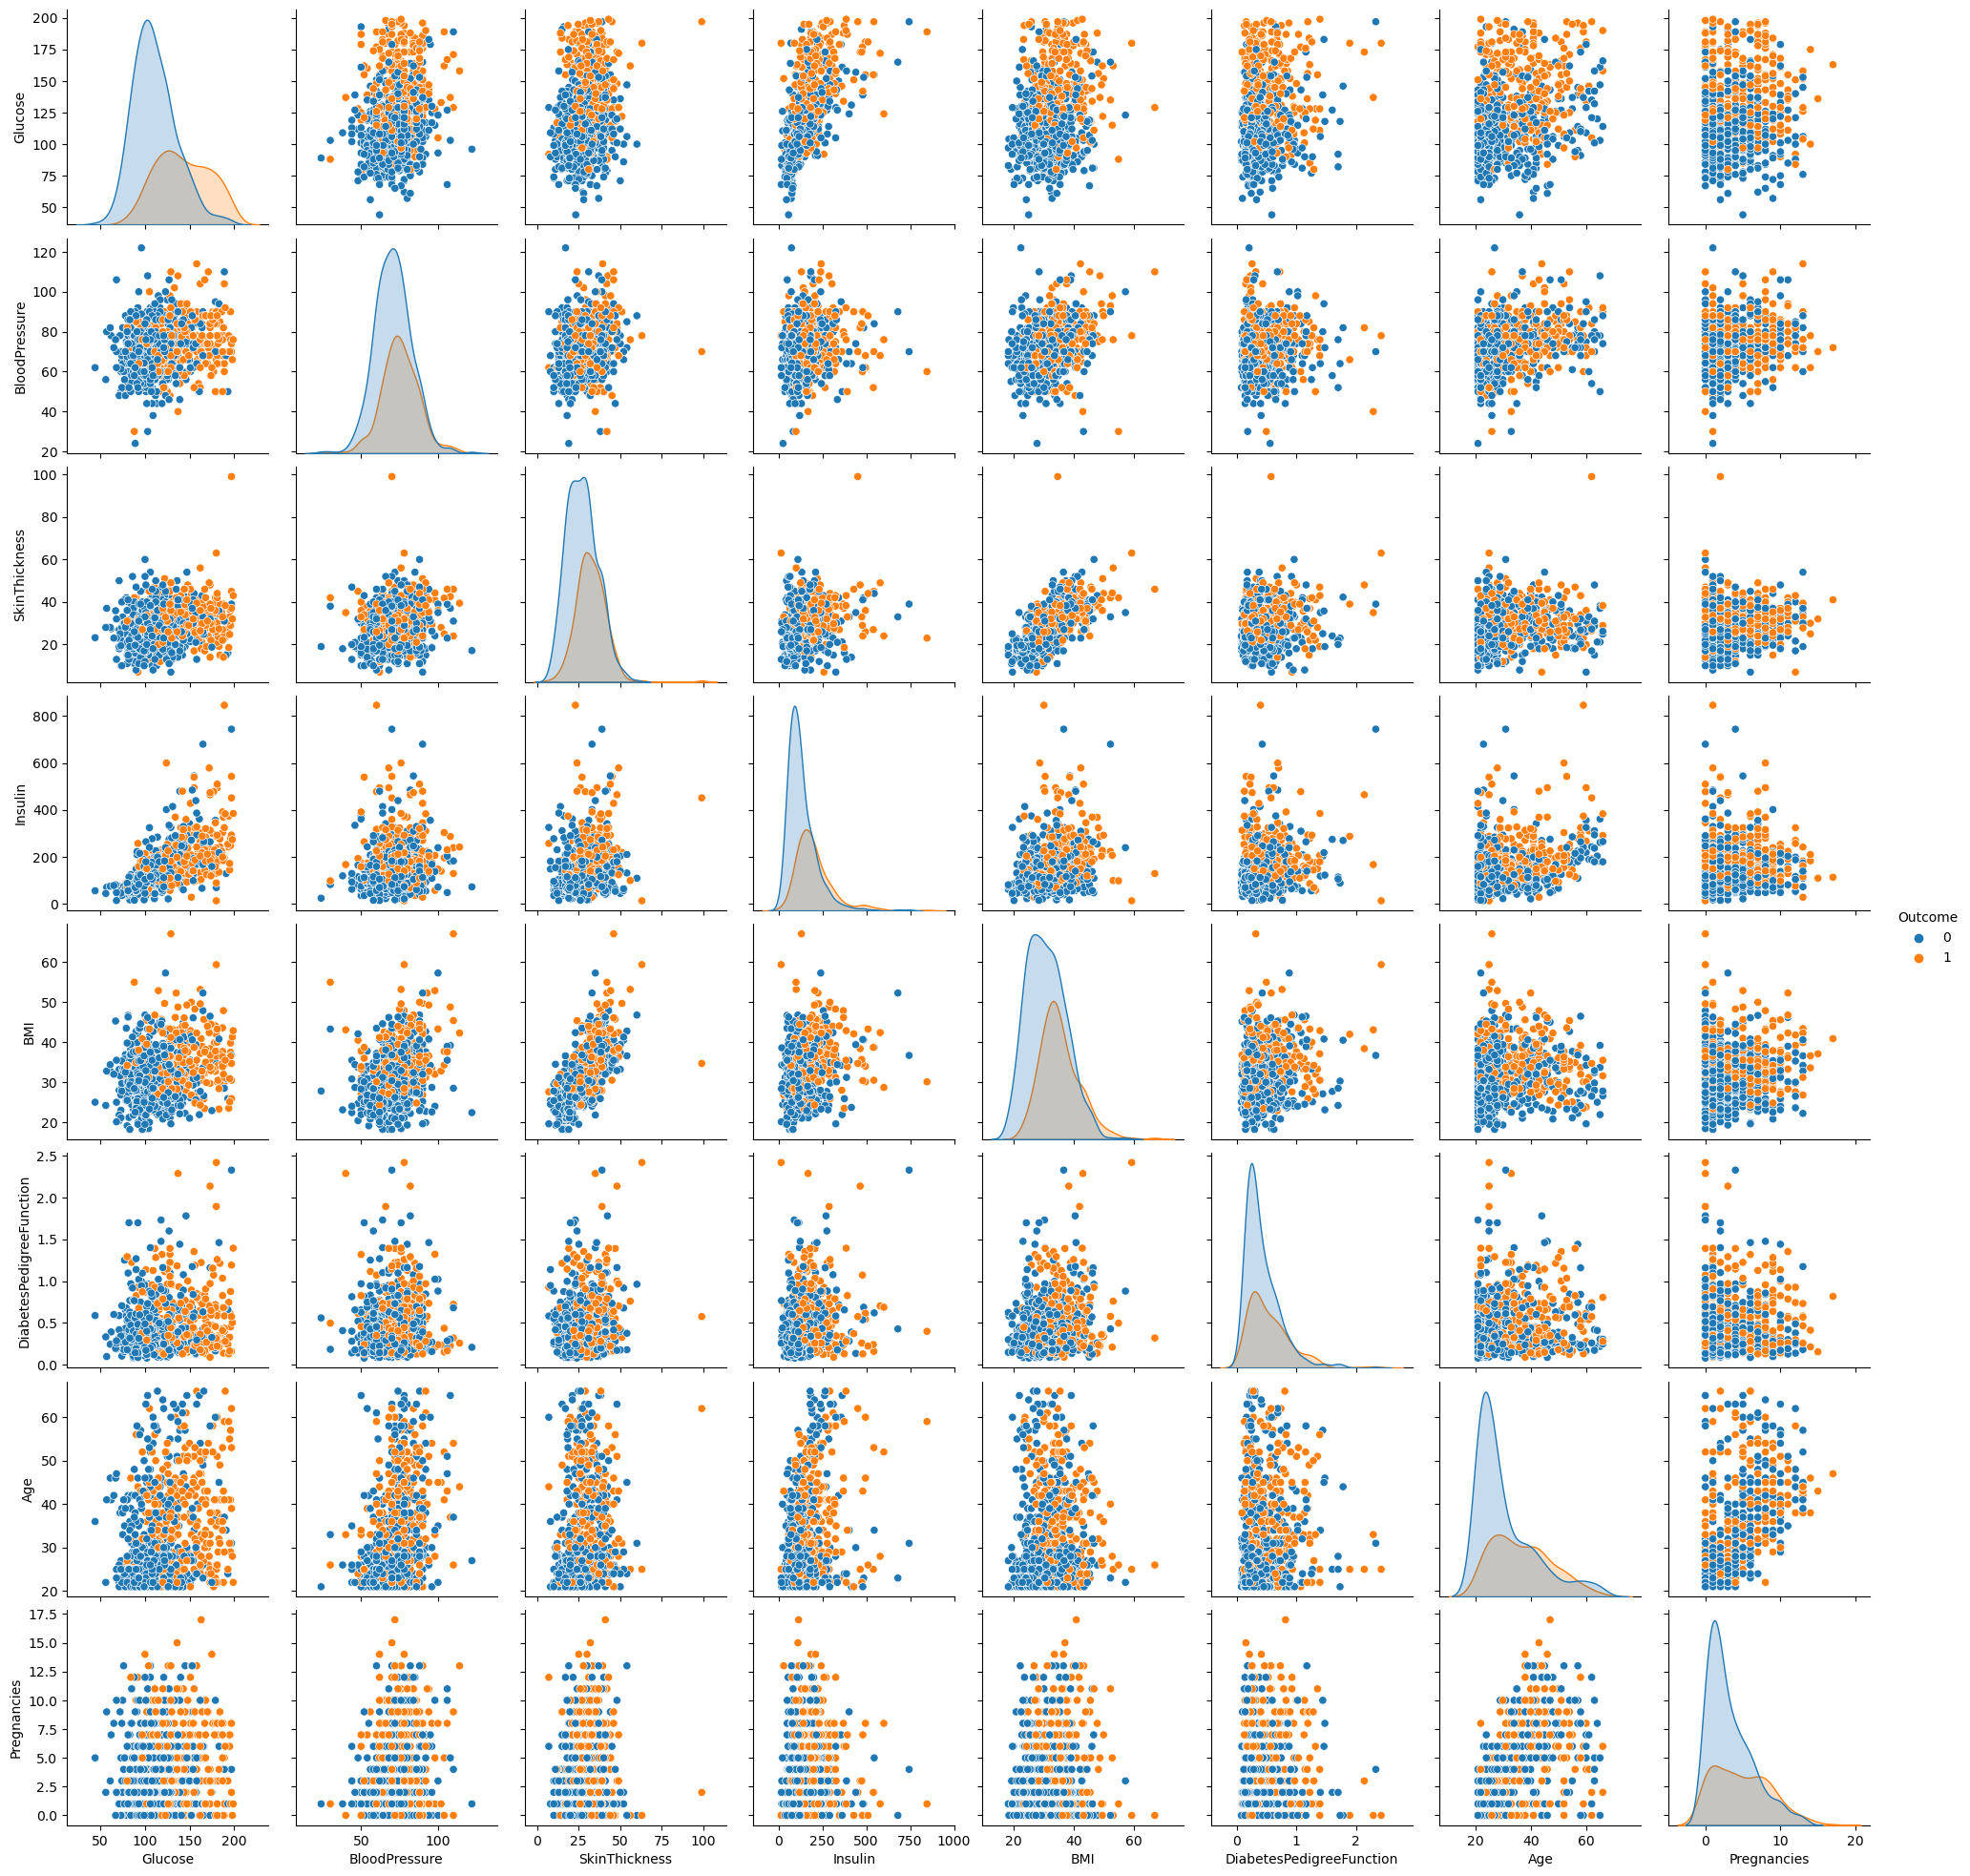

In [702]:
sns.pairplot(df, hue= 'Outcome', kind='scatter', diag_kind='auto') #To view the relationship betweeen the variables
# As seen, the relationship between the variables are not linear. 
# Except glucose and insulin that shows slight linear relationship. 

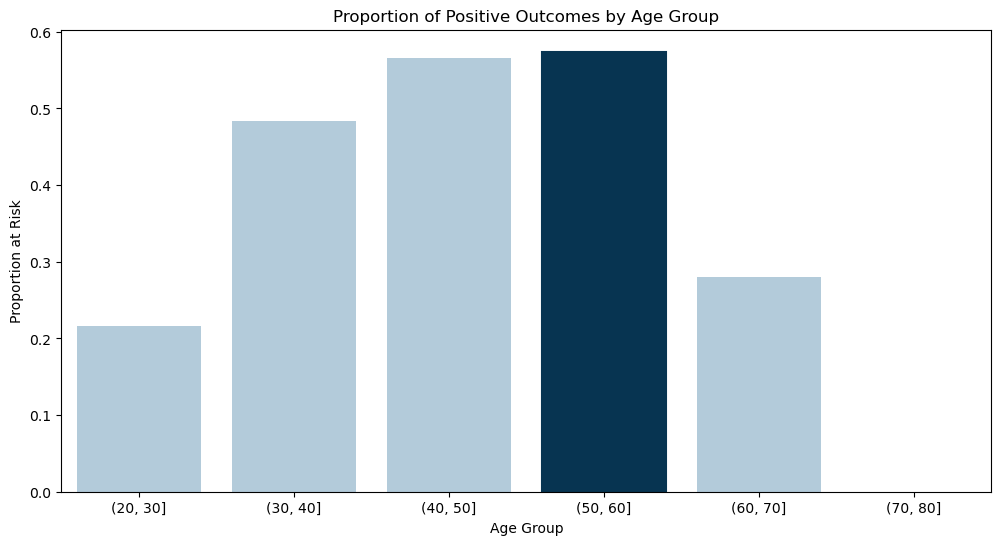

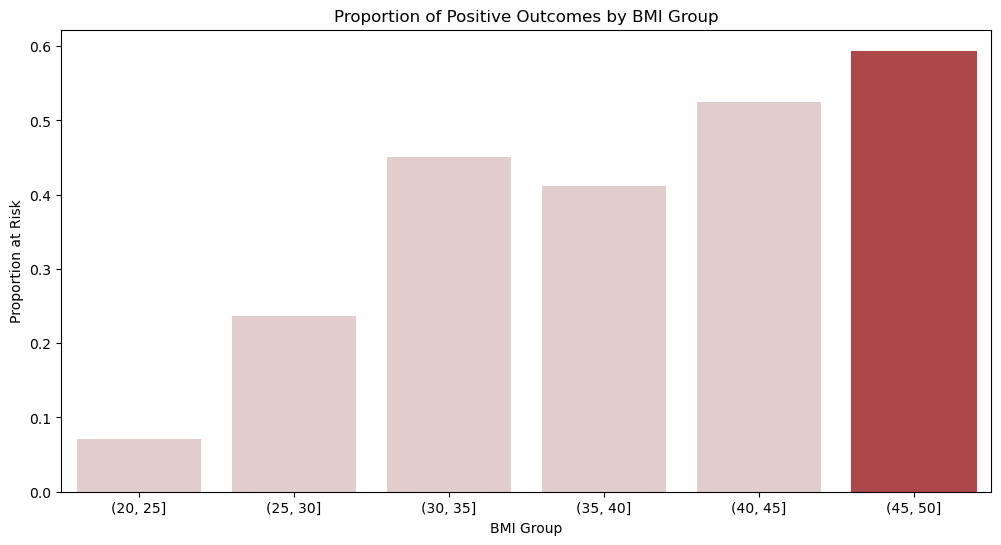

In [985]:

# Define age intervals
age_bins = [20, 30, 40, 50, 60, 70, 80]
df_imputed['AgeGroup'] = pd.cut(df_imputed['Age'], bins=age_bins)

# Define BMI intervals
bmi_bins = [20, 25, 30, 35, 40, 45, 50]
df_imputed['BMIGroup'] = pd.cut(df_imputed['BMI'], bins=bmi_bins)

# Calculate proportion of positive outcomes in each age group
age_group_risk = df_imputed.groupby('AgeGroup')['Outcome'].mean().reset_index()

# Calculate proportion of positive outcomes in each BMI group
bmi_group_risk = df_imputed.groupby('BMIGroup')['Outcome'].mean().reset_index()

# Find the index of the highest bar
max_index_age = age_group_risk['Outcome'].idxmax()

# Plot the proportion of positive outcomes by age group
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='AgeGroup', y='Outcome', data=age_group_risk, color='#ACCCE1')

# Highlight the highest bar
for bar in bars.patches:
    if bar == bars.patches[max_index_age]:
        bar.set_color('#073451')  # Change the color of the highest bar
        bar.set_linewidth(1.5)  # Increase edge line width
        
plt.title('Proportion of Positive Outcomes by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion at Risk')
plt.show()

# Plot the proportion of positive outcomes by BMI group
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='BMIGroup', y='Outcome', data=bmi_group_risk, color='#E6C9C9')

# Find the index of the highest bar
max_index_bmi = bmi_group_risk['Outcome'].idxmax()

for bar in bars.patches:
    if bar == bars.patches[max_index_bmi]:
        bar.set_color('#AC4849')  # Change the color of the highest bar
        bar.set_linewidth(1.5)  # Increase edge line width
        
plt.title('Proportion of Positive Outcomes by BMI Group')
plt.xlabel('BMI Group')
plt.ylabel('Proportion at Risk')
plt.show()

In [989]:
pivot_ui(df_imputed) # creating different plots and fruther exploring the distribution and relationships in the data.

### PREPARING FOR THE MODEL

 Selecting the features: The features as seen in the correlation matrix plot has some multicollinearity, to take care of this, i will be dropping one feature out of the two features that are correlated to each other. This choice will be decided by taking one out of the two features with less correlation to the outcome, which means the feature with the least predictive power. 
 features with strong correlation
 
1. Glucose - ~insulin~
 
2. ~SkinThickness~ - BMI

3. Age

4. Preganancies

5. BloodPressure 

6. DiabetesPedigreeFunction

   BloodPressure and DiabetesPedigreeFunction have low predictive power compared to the other selected features, but they qualified because they do not contribute to multicolinearity. Preganancies has high correlation with age, but on tuning, the model performed better with the pregancies column.  The target variable(outcome) is a category variable even though its in integers, 1 = Positive 2= Negative. Therefore, we will be building a classification model. 

In [794]:
X = df.drop(columns='Outcome')
y= df['Outcome']

In [796]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### DECISION TREE MODEL

In [768]:
dt_classifier.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [819]:
# Define the parameter grid
param_grid_D = {
    'criterion': ['gini', 'entropy'],            # The function to measure the quality of a split
    'splitter': ['best', 'random'],              # The strategy used to split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],     # The maximum depth of the tree
    'min_samples_split': [2, 5, 10],             # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],               # The minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']       # The number of features to consider when looking for the best split
}

In [821]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_D, scoring='accuracy',cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
Confusion Matrix:
[[86 13]
 [24 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        99
           1       0.70      0.56      0.63        55

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154


Accuracy Score: 0.7597402597402597


In [815]:
dt_classifier = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, max_features= None, min_samples_leaf= 4,
                                       min_samples_split= 10, splitter= 'random',random_state=42)
dt_classifier.fit(X_train,y_train)
y_pred = dt_classifier.predict(X_test)

In [817]:
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))
print("Accuracy Score:", accuracy_score(y_test,y_pred))


Confusion matrix:
[[80 19]
 [21 34]]
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        99
           1       0.64      0.62      0.63        55

    accuracy                           0.74       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154

Accuracy Score: 0.7402597402597403


In [946]:
DT_score= dt_classifier.score(X_train,y_train),dt_classifier.score(X_test,y_test)

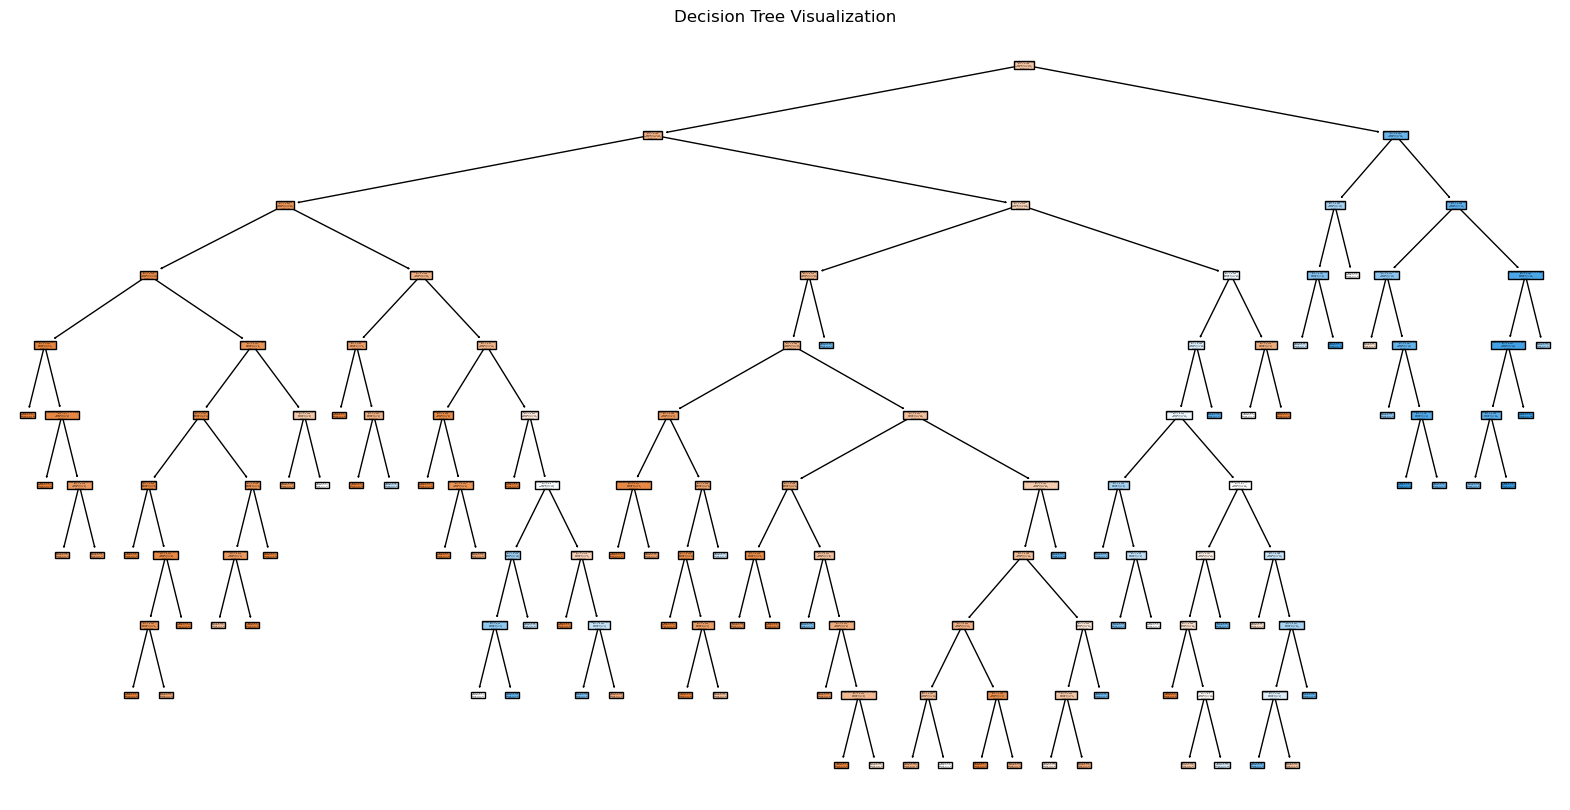

In [902]:
# Visualize the decision tree
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=X_train.columns.tolist(), 
          class_names=[str(cls) for cls in dt_classifier.classes_])
plt.title("Decision Tree Visualization")
plt.show()

In [904]:
tree_info = dt_classifier.tree_
num_nodes = tree_info.node_count
num_leaves = tree_info.n_leaves
num_decision = num_nodes - num_leaves

print("Number of nodes:", num_nodes)
print("Number of leaves:", num_leaves)
print("Number of decision:", num_decision)

Number of nodes: 143
Number of leaves: 72
Number of decision: 71


#### XGBOOST MODEL

In [831]:
# Define the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Define the hyperparameter grid
param_grid_X = {
    'n_estimators': [50, 100, 150],        # Number of boosting rounds
    'max_depth': [3, 6, 9],                # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.6, 0.8, 1.0],          # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],   # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 0.5],            # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2.0]            # L2 regularization term on weights
}


# Grid Search with Cross Validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_X,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2.0, 'subsample': 0.8}
Best Score: 0.7948020791683327


In [839]:
xgb_classifier = XGBClassifier(colsample_bytree= 1.0, gamma= 0.2, learning_rate= 0.2, max_depth= 3, n_estimators= 100,
                               reg_alpha= 0, reg_lambda= 2.0, subsample=0.8)
xgb_classifier.fit(X_train,y_train)
y_pred_X = xgb_classifier.predict(X_test)

In [865]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_X))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_X))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_X))

Confusion Matrix:
[[80 19]
 [18 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


Accuracy Score: 0.7597402597402597


In [940]:
XGB_score = xgb_classifier.score(X_train,y_train), xgb_classifier.score(X_test,y_test)

### RANDOM FOREST MODEL

In [847]:
# Define the hyperparameter grid
param_grid_RF = {
    'n_estimators': [50, 100, 150],             # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
}


In [853]:
# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_RF, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_RF = best_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_RF))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_RF))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Confusion Matrix:
[[80 19]
 [18 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


Accuracy Score: 0.7597402597402597


In [861]:
RF_classifier = RandomForestClassifier(bootstrap= False, max_depth= 10, max_features= 'log2', min_samples_leaf= 4, min_samples_split= 2,
                                       n_estimators=50)
RF_classifier.fit(X_train,y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [863]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_RF))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_RF))


Confusion Matrix:
[[81 18]
 [17 38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        99
           1       0.68      0.69      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154


Accuracy Score: 0.7727272727272727


In [928]:
RF_score = RF_classifier.score(X_train,y_train) , RF_classifier.score(X_test,y_test)

In [958]:
RF_score

(0.9788273615635179, 0.7727272727272727)

In [966]:
model_performance = pd.DataFrame([RF_score,XGB_score,DT_score],
                                 ['Random_Forest','XGBoost','Decision_Tree'], 
                                 columns = ['Train_score','Test_score'])

In [968]:
model_performance

,Train_score,Test_score
Random_Forest,0.978827,0.772727
XGBoost,0.969055,0.733766
Decision_Tree,0.820847,0.740260


#### CONCLUSION
**Decision tree** model is the preferred model, as it shows no signs of overfitting and the test score is also 
not poor in relation to the train score